In [1]:
import math
from collections.abc import Iterable
from itertools import pairwise, chain
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import polars as pl
import seaborn as sns
import tqdm.auto as tqdm
from torch import nn

# %env KERAS_BACKEND=torch
#
# import keras
# from keras import layers
# import keras_tuner

# torch.set_float32_matmul_precision("high")

In [2]:
from pathlib import Path
import os

if not Path("./src/kernels").is_dir():
    for parent_path in Path.cwd().parents:
        if (parent_path / "src/kernels").is_dir():
            os.chdir(parent_path)
            break
    else:
        raise FileNotFoundError("Can't find project root")

assert Path("./src/kernels").is_dir()

In [3]:
from src import kernels, convolutions
from src.models import simple_lenet
from src import load_data

In [226]:
import importlib

# from src.kernels import quadratic as quad_kernels
import src.models.simple_lenet
import src.load_data
import src.models.utils
import src.kernels.quadratic
import src.convolutions.cuda_select

importlib.reload(src.kernels.quadratic)
importlib.reload(src.kernels)
importlib.reload(src.kernels.utils)
importlib.reload(src.convolutions.cuda_select)
importlib.reload(src.convolutions.unfold_broadcast)
importlib.reload(src.models.utils)
importlib.reload(src.models.simple_lenet)
importlib.reload(src.load_data)
from src.models import simple_lenet
from src import load_data

# kernels = importlib.reload(kernels)
# convolutions = importlib.reload(convolutions)

In [5]:
k_mnist = load_data.k_mnist()
k_mnist

Dataset(x_train=(60000, 1, 28, 28), x_test=(10000, 1, 28, 28), y_train=(60000,), y_test=(10000,))

In [178]:
# def build_model(
#         hp: keras_tuner.HyperParameters, debug: bool = False, init: str | float = 3.0
# ) -> keras.Model:
#     pool_fn_name = hp.Choice("pool_fn", list(simple_lenet.LENET_POOLING_FUNCTIONS))
#     pool_fn = simple_lenet.LENET_POOLING_FUNCTIONS[pool_fn_name]
#     return (
#         simple_lenet.LeNet(
#             img_channels=1,
#             num_classes=10,
#             pool_fn=pool_fn,
#             debug=debug,
#             init=init,
#         )
#         .to("cuda")
#         .to_keras(k_mnist, extra_name=pool_fn_name)
#     )

In [6]:
xt, yt = (
    torch.as_tensor(k_mnist.x_train, device="cuda"),
    torch.as_tensor(k_mnist.y_train, device="cuda"),
)

In [228]:
# from collections import defaultdict
#
#
# class InspectScales(keras.callbacks.Callback):
#     store_targets = {
#         kernels.QuadraticKernelIso2D: ("log_stds",),
#         kernels.utils.LearnedSpectral2D: ("log_stds", "thetas"),
#     }
#
#     def __init__(self, store: dict[str, list[np.ndarray] | np.ndarray], per_batch: bool = False):
#         super().__init__()
#         self.mod_counter = 0
#         self.store = store
#         self.per_batch = per_batch
#
#     def on_epoch_end(self, epoch, logs=None):
#         if not self.per_batch:
#             self.mod_counter = 0
#             self.recurse_mod(self.model.layers[0].module)
#
#     def on_train_batch_end(self, batch, logs=None):
#         if self.per_batch:
#             self.mod_counter = 0
#             self.recurse_mod(self.model.layers[0].module)
#
#     def recurse_mod(self, mod: torch.nn.Module):
#         for child in mod.children():
#             cls = type(child)
#             if cls not in self.store_targets:
#                 self.recurse_mod(child)
#                 continue
#
#             num, self.mod_counter = self.mod_counter, self.mod_counter + 1
#             targets = self.store_targets[cls]
#             for target in targets:
#                 val = getattr(child, target).squeeze().numpy(force=True)
#                 self.store.setdefault(f"{num}.{target}", []).append(val)
#
#     def on_train_end(self, logs=None):
#         for name, vals in self.store.items():
#             self.store[name] = np.stack(vals)

In [266]:
# from tqdm.keras import TqdmCallback
#
# torch._dynamo.reset()
# test_hp = keras_tuner.HyperParameters()
# test_hp.Fixed("pool_fn", "standard-2")
# test_model = build_model(test_hp, init="spin", debug=False)
# scales = {}
#
# # with torch.autograd.detect_anomaly():
# hist = test_model.fit(
#     xt,
#     yt,
#     batch_size=32,
#     epochs=5,
#     callbacks=[
#         TqdmCallback(verbose=0),
#         # keras.callbacks.EarlyStopping(start_from_epoch=60, patience=10, verbose=True),
#         InspectScales(scales, per_batch=False)
#     ],
#     validation_split=1 / 6,
#     validation_batch_size=20_000,
# )

0epoch [00:00, ?epoch/s]

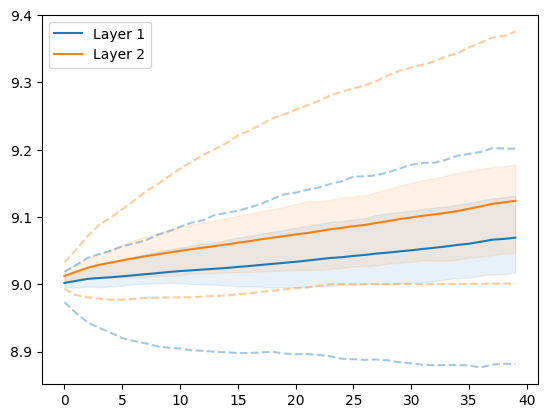

In [265]:
def plot_ci(vals: np.ndarray, ax: plt.Axes = None, label: str = ""):
    assert len(vals.shape) == 2, "Cannot plot multiple val types"
    if ax is None:
        _, ax = plt.subplots()

    q0, q1, q3, q4 = np.quantile(vals, [0, 0.25, 0.75, 1], axis=1)
    colour = ax.plot(vals.mean(axis=1), label=label)[0].get_color()
    ax.plot(q0, color=colour, linestyle="dashed", alpha=0.4)
    ax.plot(q4, color=colour, linestyle="dashed", alpha=0.4)
    ax.fill_between(range(len(vals)), q1, q3, color=colour, alpha=0.1)


_, test_ax = plt.subplots()
plot_ci(scales["0.log_stds"][..., 0], ax=test_ax, label="Layer 1")
# plot_ci(scales['0.thetas'], ax=test_ax, label="Layer 1")
plot_ci(scales["1.log_stds"][..., 0], ax=test_ax, label="Layer 2")
# plot_ci(scales['1.thetas'], ax=test_ax, label="Layer 2")
plt.legend()

In [234]:
np.quantile(scales["0.log_stds"], [0, 0.25, 0.75, 1], axis=1)

array([[5.00124502, 5.01840639, 5.03886414, 5.04413652, 5.07203484,
        5.08115625, 5.10532141, 5.11548328, 5.14212465, 5.15606451],
       [5.11739457, 5.18777776, 5.24617743, 5.29276001, 5.34578133,
        5.38976574, 5.45224094, 5.47871959, 5.52440035, 5.55995977],
       [5.18108499, 5.27683342, 5.38017368, 5.46463323, 5.58360875,
        5.65384352, 5.74113262, 5.82092738, 5.87248981, 5.92792177],
       [5.21381474, 5.32263422, 5.44992685, 5.56090355, 5.69311333,
        5.78343487, 5.90698147, 5.99024725, 6.08859396, 6.16753626]])

In [241]:
d[0].get_color()

'#1f77b4'

In [27]:
hist

In [188]:
test_model.layers[0].module.net[2].kernel()

tensor([[[[0.0384, 0.0235, 0.0185, 0.0235, 0.0384],
          [0.0246, 0.0096, 0.0046, 0.0096, 0.0246],
          [0.0199, 0.0050, 0.0000, 0.0050, 0.0199],
          [0.0246, 0.0096, 0.0046, 0.0096, 0.0246],
          [0.0384, 0.0235, 0.0185, 0.0235, 0.0384]]],


        [[[0.0434, 0.0273, 0.0219, 0.0273, 0.0434],
          [0.0270, 0.0109, 0.0055, 0.0109, 0.0270],
          [0.0215, 0.0054, 0.0000, 0.0054, 0.0215],
          [0.0270, 0.0109, 0.0055, 0.0109, 0.0270],
          [0.0434, 0.0273, 0.0219, 0.0273, 0.0434]]],


        [[[0.0402, 0.0249, 0.0198, 0.0249, 0.0402],
          [0.0254, 0.0101, 0.0050, 0.0101, 0.0254],
          [0.0204, 0.0051, 0.0000, 0.0051, 0.0204],
          [0.0254, 0.0101, 0.0050, 0.0101, 0.0254],
          [0.0402, 0.0249, 0.0198, 0.0249, 0.0402]]],


        [[[0.0407, 0.0256, 0.0206, 0.0256, 0.0407],
          [0.0253, 0.0102, 0.0051, 0.0102, 0.0253],
          [0.0201, 0.0050, 0.0000, 0.0050, 0.0201],
          [0.0253, 0.0102, 0.0051, 0.0102, 0.0253],


In [255]:
# test_model.evaluate(
#     k_mnist.x_test, k_mnist.y_test, batch_size=10_000, verbose=False, return_dict=True
# )

{'accuracy': 0.10000000149011612,
 'loss': 2.302596092224121,
 'top3': 0.30000001192092896}

In [128]:
q2_5.state_dict()

OrderedDict([('pos_grid',
              tensor([[-2., -2.],
                      [-2., -1.],
                      [-2.,  0.],
                      [-2.,  1.],
                      [-2.,  2.],
                      [-1., -2.],
                      [-1., -1.],
                      [-1.,  0.],
                      [-1.,  1.],
                      [-1.,  2.],
                      [ 0., -2.],
                      [ 0., -1.],
                      [ 0.,  0.],
                      [ 0.,  1.],
                      [ 0.,  2.],
                      [ 1., -2.],
                      [ 1., -1.],
                      [ 1.,  0.],
                      [ 1.,  1.],
                      [ 1.,  2.],
                      [ 2., -2.],
                      [ 2., -1.],
                      [ 2.,  0.],
                      [ 2.,  1.],
                      [ 2.,  2.]], device='cuda:0')),
             ('covs.log_stds',
              tensor([[[ 0.5216,  1.1183],
                       [ 0.829

In [205]:
kernels.QuadraticKernelIso2D(1, 1, 5, init=3.7)()

tensor([[[[-0.5405, -0.3378, -0.2703, -0.3378, -0.5405],
          [-0.3378, -0.1351, -0.0676, -0.1351, -0.3378],
          [-0.2703, -0.0676, -0.0000, -0.0676, -0.2703],
          [-0.3378, -0.1351, -0.0676, -0.1351, -0.3378],
          [-0.5405, -0.3378, -0.2703, -0.3378, -0.5405]]]],
       grad_fn=<ViewBackward0>)

In [207]:
importlib.reload(src.kernels.utils)
importlib.reload(src.kernels.quadratic)
importlib.reload(src.kernels)
k2 = kernels.QuadraticKernelSpectral2D(1, 1, 5, init=3.7)
k3 = kernels.QuadraticKernelCholesky2D(1, 1, 5, init=3.7)
k3()

tensor([[[[-0.5405, -0.3378, -0.2703, -0.3378, -0.5405],
          [-0.3378, -0.1351, -0.0676, -0.1351, -0.3378],
          [-0.2703, -0.0676, -0.0000, -0.0676, -0.2703],
          [-0.3378, -0.1351, -0.0676, -0.1351, -0.3378],
          [-0.5405, -0.3378, -0.2703, -0.3378, -0.5405]]]],
       grad_fn=<MulBackward0>)

In [186]:
k2.covs.cov()

tensor([[[[3.0000, 0.0000],
          [0.0000, 3.0000]]]], grad_fn=<LinalgInvExBackward0>)

In [196]:
torch.einsum("kx,xX,kX->k", k2.pos_grid, torch.linalg.inv(k2.covs.cov()[0, 0]), k2.pos_grid).reshape(1, 5, 5)

tensor([[[2.6667, 1.6667, 1.3333, 1.6667, 2.6667],
         [1.6667, 0.6667, 0.3333, 0.6667, 1.6667],
         [1.3333, 0.3333, 0.0000, 0.3333, 1.3333],
         [1.6667, 0.6667, 0.3333, 0.6667, 1.6667],
         [2.6667, 1.6667, 1.3333, 1.6667, 2.6667]]], grad_fn=<ViewBackward0>)

In [7]:
res = {}

In [209]:
importlib.reload(src.models.simple_lenet)
importlib.reload(src.load_data)
importlib.reload(src.kernels.quadratic)
importlib.reload(src.kernels)
from src.models import simple_lenet
from src import load_data

# pool_fn = 'iso-5'
for pool_fn in tqdm.tqdm(simple_lenet.LENET_POOLING_FUNCTIONS, desc="Pooling types", unit="trial"):
    res[pool_fn] = simple_lenet.LeNet.fit_many(k_mnist, pool_fn=pool_fn, init="uniform")

Pooling types:   0%|          | 0/10 [00:00<?, ?trial/s]

standard-2:   0%|          | 0/20 [00:00<?, ?run/s]

standard-3:   0%|          | 0/20 [00:00<?, ?run/s]

standard-5:   0%|          | 0/20 [00:00<?, ?run/s]

standard-7:   0%|          | 0/20 [00:00<?, ?run/s]

iso-3:   0%|          | 0/20 [00:00<?, ?run/s]

iso-5:   0%|          | 0/20 [00:00<?, ?run/s]

iso-7:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-3:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-5:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-7:   0%|          | 0/20 [00:00<?, ?run/s]

In [229]:
for size in tqdm.tqdm((3, 5, 7), desc="Aniso sizes", unit="trial"):
    res[f"aniso-{size}-spin"] = simple_lenet.LeNet.fit_many(k_mnist, pool_fn=f"aniso-{size}", init="spin")
    res[f"aniso-{size}-uiso"] = simple_lenet.LeNet.fit_many(k_mnist, pool_fn=f"aniso-{size}", init="uniform-iso")

Aniso sizes:   0%|          | 0/3 [00:00<?, ?trial/s]

aniso-3:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-3:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-5:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-5:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-7:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-7:   0%|          | 0/20 [00:00<?, ?run/s]

In [42]:
np.prod([32, 20, 1, 25, 144])

np.int64(2304000)

In [9]:
thierry = {
    "standard": {
        "accuracy": [0.9479, 0.9553, 0.9533, 0.9502, 0.9515, 0.9565, 0.9542, 0.9523, 0.9559, 0.9531, 0.9542, 0.9493,
                     0.9576,
                     0.9538, 0.954, 0.9576, 0.9511, 0.9577, 0.9534, 0.9545],
        "avg_f1": [0.9480427059346676, 0.955243521346825, 0.9532310508868616, 0.9500373432938061, 0.9516442963137285,
                   0.9564962937071735, 0.9542214833862793, 0.9523321417368932, 0.9558427875183473, 0.9532747950097995,
                   0.9543660808292007, 0.9492208800212568, 0.9575739495682429, 0.9538378284609481, 0.953943950884279,
                   0.9575911856140872, 0.9510849143581043, 0.9577136484072426, 0.9533366066116284, 0.954436550442954],
        "avg_precision": [0.9488830713394076, 0.9558271464297243, 0.9539802093110161, 0.95082666027619,
                          0.9524851056861998,
                          0.9570759254110802, 0.9549093282943403, 0.9529150767456667, 0.9565553359162016,
                          0.9539470341384829, 0.954918286302562, 0.9496442333541761, 0.9577186369829251,
                          0.9543388547817999,
                          0.9543400434986434, 0.9579429938754332, 0.9516237503385178, 0.9583492148509896,
                          0.9540375935298817, 0.9550695955259301],
        "avg_recall": [0.9479, 0.9552999999999999, 0.9532999999999999, 0.9502, 0.9515, 0.9564999999999999,
                       0.9542000000000002, 0.9522999999999999, 0.9558999999999997, 0.9530999999999998,
                       0.9541999999999999,
                       0.9493, 0.9575999999999999, 0.9538, 0.954, 0.9575999999999999, 0.9511000000000001, 0.9577,
                       0.9533999999999999, 0.9545000000000001],
        "time": [11.336342573165894, 11.205965518951416, 11.126548290252686, 11.144952774047852, 11.333316802978516,
                 11.117565393447876, 11.225554943084717, 11.122453212738037, 11.118192911148071, 11.064157247543335,
                 11.218071222305298, 11.085448265075684, 11.308237075805664, 11.059718608856201, 11.14068603515625,
                 11.235052108764648, 11.091073274612427, 11.040074825286865, 11.204321384429932, 11.172889471054077]},
    "mp_parabola": {
        "accuracy": [0.9508, 0.9529, 0.9522, 0.9484, 0.9369, 0.9619, 0.9558, 0.9568, 0.9308, 0.9521, 0.9447,
                     0.9509, 0.9501, 0.9513, 0.9371, 0.9516, 0.9485, 0.9467, 0.9503, 0.9475],
        "avg_f1": [0.950806360476966, 0.9529633225456344, 0.9521517864935343, 0.9485081018518793,
                   0.9371195818519602, 0.9618790190569702, 0.9558654154351375, 0.9568133053103347,
                   0.9314778459359815, 0.9523666557831321, 0.9448033435863467, 0.9506727300655873,
                   0.9501985886886664, 0.9512553490850604, 0.9370694224148679, 0.9516683046401162,
                   0.9485618275051382, 0.9467167628837065, 0.9504908930502335, 0.9477866149194035],
        "avg_precision": [0.9517560967252298, 0.95358990509561, 0.9528444499199372, 0.9491530559090826,
                          0.9397894762680842, 0.9621019098480174, 0.9567228865373307, 0.9571406159189323,
                          0.9364384966280743, 0.9536422404348774, 0.946335449315826, 0.9511303107565908,
                          0.9513358171642154, 0.9521138882018374, 0.9393618259230054, 0.9525137919765345,
                          0.9504892184319234, 0.9472548494306672, 0.9524737893355812, 0.9503791588289413],
        "avg_recall": [0.9508000000000001, 0.9529, 0.9522, 0.9484, 0.9369, 0.9619, 0.9558, 0.9568000000000001,
                       0.9308, 0.9521000000000001, 0.9447000000000001, 0.9508999999999999, 0.9501000000000002,
                       0.9513, 0.9371, 0.9516, 0.9485000000000001, 0.9467000000000001, 0.9503, 0.9475],
        "time": [19.95300531387329, 19.966599464416504, 21.286937713623047, 20.27017569541931,
                 20.238272666931152, 21.34596848487854, 22.15380358695984, 20.756579637527466,
                 19.923376083374023, 21.297425746917725, 21.22718071937561, 19.8521089553833, 20.369531869888306,
                 21.07774591445923, 22.265422582626343, 22.171162843704224, 20.52251696586609,
                 22.132704257965088, 22.15888285636902, 22.12217879295349]},
    "std_parabolic": {
        "accuracy": [0.954, 0.9601, 0.9616, 0.9552, 0.957, 0.9496, 0.9574, 0.9588, 0.9618, 0.9571, 0.9564, 0.9563,
                     0.9595, 0.9601, 0.9548, 0.9582, 0.9519, 0.9507, 0.9564, 0.9603],
        "avg_f1": [0.9540863566164054, 0.9600246055686295, 0.9615994821729175, 0.9552464207426888, 0.9571109973724019,
                   0.9497242909682451, 0.9574604474078996, 0.9588338148280879, 0.961844851372286, 0.9571691282161524,
                   0.9565089641626277, 0.9565222935573601, 0.959522075136977, 0.9601979840531273, 0.9549325128981534,
                   0.9581116586814071, 0.9519149876179334, 0.9509130607139857, 0.9563618022922269, 0.9602775485761935],
        "avg_precision": [0.955754648433123, 0.9605257639873204, 0.9620565922288578, 0.956006385355191,
                          0.9582834986219535, 0.9512320074534466, 0.9583170721892609, 0.9590811061571592,
                          0.9626378524977829, 0.9579883072229535, 0.9575209823830131, 0.9576551077167297,
                          0.9599547977300565, 0.9606275879992552, 0.9562698474693023, 0.9584332308666907,
                          0.9527944673493695, 0.9520370251785624, 0.9565325135565012, 0.9606329534103916],
        "avg_recall": [0.954, 0.9601, 0.9616, 0.9551999999999998, 0.9570000000000001, 0.9496, 0.9574,
                       0.9587999999999999, 0.9618000000000002, 0.9571000000000002, 0.9564, 0.9563, 0.9594999999999999,
                       0.9601, 0.9548, 0.9582, 0.9519000000000002, 0.9507, 0.9564, 0.9603000000000002],
        "time": [22.197277069091797, 21.563359022140503, 22.047484636306763, 22.181645393371582, 21.075055599212646,
                 19.944994688034058, 19.990905284881592, 19.94177007675171, 20.003604888916016, 20.52237844467163,
                 20.597529649734497, 21.686691522598267, 20.011598348617554, 19.968311071395874, 20.11429476737976,
                 19.996861457824707, 19.970699548721313, 19.993578672409058, 19.95755696296692, 20.15055513381958]},
    "std_parabolic_scale_space": {
        "accuracy": [0.9491, 0.9651, 0.9407, 0.9629, 0.9593, 0.9635, 0.9563, 0.9519, 0.9646, 0.9613, 0.96,
                     0.9594, 0.948, 0.9584, 0.9588, 0.961, 0.9495, 0.9615, 0.9588, 0.9491],
        "avg_f1": [0.9489968909694314, 0.9651154649705062, 0.941009801527423, 0.962848110862943,
                   0.9593033463513952, 0.963491821916107, 0.9563415476677406, 0.95185967159678,
                   0.9646227824406675, 0.9613338072799531, 0.9599392410000946, 0.9593880503285721,
                   0.9481734152378125, 0.9584862041616082, 0.9587977977601204, 0.9609145543819766,
                   0.9495937934390775, 0.9614744244911814, 0.9587908930335496, 0.9491681795200874],
        "avg_precision": [0.9501875898751105, 0.9653526230917961, 0.9444916748799569, 0.9629668147230417,
                          0.9599769721112482, 0.9637338105276141, 0.9569258185863786, 0.9523858292093876,
                          0.9650369888631276, 0.9617665830848632, 0.9605290086892821, 0.9601160153293566,
                          0.9494652166686347, 0.9591334657342946, 0.9594222758576538, 0.9611797491260063,
                          0.9509023212453362, 0.9616189427870616, 0.9592653560787723, 0.9509167274667817],
        "avg_recall": [0.9490999999999999, 0.9651, 0.9407, 0.9629, 0.9593, 0.9634999999999998,
                       0.9562999999999999, 0.9519, 0.9645999999999999, 0.9612999999999999, 0.96,
                       0.9594000000000001, 0.9480000000000001, 0.9583999999999999, 0.9587999999999999, 0.961,
                       0.9494999999999999, 0.9615, 0.9588000000000001, 0.9490999999999999],
        "time": [21.15693473815918, 22.425765991210938, 21.332035541534424, 20.103604078292847,
                 20.699523210525513, 21.179635286331177, 20.044978857040405, 20.229622840881348,
                 20.441341876983643, 20.54746103286743, 20.05719757080078, 20.084423780441284,
                 20.296043634414673, 20.059288263320923, 20.080735683441162, 20.03710913658142,
                 20.225708484649658, 20.34082865715027, 20.137271642684937, 22.373881816864014]}
}

In [32]:
torch.manual_seed(0)
test_model = simple_lenet.LeNet(1, 10, "iso-5", init="uniform").cuda()
test_model

LeNet(
  (net): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): GenericConv2D(
      padding=2, stride=2, groups=20
      (kernel): QuadraticKernelIso2D(1, 20, kernel_size=5)
      (conv): SelectConvFixedLazy()
    )
    (3): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): GenericConv2D(
      padding=2, stride=2, groups=50
      (kernel): QuadraticKernelIso2D(1, 50, kernel_size=5)
      (conv): SelectConvFixedLazy()
    )
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=800, out_features=500, bias=True)
    (8): ReLU()
    (9): Linear(in_features=500, out_features=10, bias=True)
  )
)

In [33]:



test_model.fit(k_mnist, shuffle=False)

Training:   0%|          | 0/1 [00:00<?, ?epoch/s]

tensor([8, 7, 0, 1, 4, 2, 4, 8, 1, 1, 5, 1, 0, 5, 7, 6, 1, 7, 9, 5, 7, 3, 7, 5,
        6, 6, 2, 7, 6, 0, 9, 6], device='cuda:0')
tensor([[-2.2658, -2.3031, -2.2579, -2.3716, -2.3231, -2.3321, -2.2859, -2.2985,
         -2.3104, -2.2825],
        [-2.2767, -2.2917, -2.2550, -2.3501, -2.3420, -2.3212, -2.2991, -2.3042,
         -2.3065, -2.2831],
        [-2.2872, -2.2792, -2.2504, -2.3659, -2.3358, -2.3196, -2.2974, -2.2944,
         -2.3124, -2.2883],
        [-2.2827, -2.3025, -2.2670, -2.3358, -2.3345, -2.3079, -2.3057, -2.3028,
         -2.3016, -2.2875],
        [-2.2699, -2.2727, -2.2484, -2.3575, -2.3286, -2.3198, -2.3010, -2.2994,
         -2.2991, -2.3344],
        [-2.2833, -2.2803, -2.2670, -2.3476, -2.3301, -2.3196, -2.2967, -2.3029,
         -2.3042, -2.2967],
        [-2.2633, -2.2808, -2.2483, -2.3611, -2.3248, -2.3275, -2.3036, -2.3196,
         -2.2997, -2.3022],
        [-2.2899, -2.3072, -2.2542, -2.3651, -2.3279, -2.3211, -2.2918, -2.2936,
         -2.2963, -2.2828]

KeyboardInterrupt: Interrupted by user

In [26]:
k_mnist.x_train.min()

np.float32(0.0)

In [48]:
xs, ys = torch.as_tensor(k_mnist.x_train, device='cuda'), torch.as_tensor(k_mnist.y_train, device='cuda')
xs.shape

torch.Size([60000, 1, 28, 28])

In [27]:
ys[:32]

tensor([8, 7, 0, 1, 4, 2, 4, 8, 1, 1, 5, 1, 0, 5, 7, 6, 1, 7, 9, 5, 7, 3, 7, 5,
        6, 6, 2, 7, 6, 0, 9, 6], device='cuda:0')

In [36]:
test_model[5]

LeNet(
  (net): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): GenericConv2D(
      padding=2, stride=2, groups=20
      (kernel): QuadraticKernelIso2D(1, 20, kernel_size=5)
      (conv): SelectConvFixed()
    )
    (3): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): GenericConv2D(
      padding=2, stride=2, groups=50
      (kernel): QuadraticKernelIso2D(1, 50, kernel_size=5)
      (conv): SelectConvFixed()
    )
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=800, out_features=500, bias=True)
    (8): ReLU()
    (9): Linear(in_features=500, out_features=10, bias=True)
  )
)

In [73]:
xs[:32].mean()

tensor(0.1871, device='cuda:0')

In [78]:
test_model.net[5].kernel.log_std

Parameter containing:
tensor([[3.4661],
        [0.8653],
        [2.2865],
        [0.7337],
        [0.2420],
        [0.9981],
        [1.4310],
        [0.6544],
        [0.4962],
        [1.6048],
        [2.3351],
        [1.4733],
        [2.3547],
        [1.1349],
        [0.1880],
        [1.5911],
        [0.3009],
        [3.2277],
        [0.3727],
        [3.8233],
        [0.6095],
        [2.7970],
        [3.1033],
        [0.5686],
        [2.0875],
        [3.9230],
        [3.9734],
        [0.2107],
        [2.3873],
        [3.3629],
        [1.1797],
        [2.9512],
        [1.1813],
        [3.5371],
        [3.2330],
        [1.1541],
        [3.8338],
        [2.3911],
        [1.7559],
        [3.1527],
        [2.5125],
        [1.5615],
        [1.2809],
        [3.6072],
        [0.9513],
        [0.4876],
        [1.4580],
        [0.9094],
        [2.6009],
        [2.1229]], device='cuda:0', requires_grad=True)

In [62]:
test_model.net[5].kernel()[3]

tensor([[[-2.7260, -1.7037, -1.3630, -1.7037, -2.7260],
         [-1.7037, -0.6815, -0.3407, -0.6815, -1.7037],
         [-1.3630, -0.3407, -0.0000, -0.3407, -1.3630],
         [-1.7037, -0.6815, -0.3407, -0.6815, -1.7037],
         [-2.7260, -1.7037, -1.3630, -1.7037, -2.7260]]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [75]:
res = test_model(xs[:32])
torch.log_softmax(res, dim=1).numpy(force=True)[:4, :4]

array([[-2.2657673, -2.3030846, -2.2578933, -2.3716404],
       [-2.2766986, -2.2917407, -2.2549603, -2.3501327],
       [-2.2871745, -2.279163 , -2.250412 , -2.3658538],
       [-2.282691 , -2.3025365, -2.267029 , -2.3357558]], dtype=float32)

In [76]:
nn.functional.cross_entropy(res, ys[:32])

tensor(2.3054, device='cuda:0', grad_fn=<NllLossBackward0>)

In [77]:
nn.functional.cross_entropy(res, ys[:32]).backward()

In [79]:
print(test_model.net[5].kernel.log_std.grad)

tensor([[-1.7862e-05],
        [-0.0000e+00],
        [-1.0996e-04],
        [-0.0000e+00],
        [-0.0000e+00],
        [-0.0000e+00],
        [ 1.4334e-04],
        [-0.0000e+00],
        [-0.0000e+00],
        [-3.2585e-04],
        [ 7.1240e-05],
        [-2.0357e-04],
        [-8.8747e-05],
        [-0.0000e+00],
        [-0.0000e+00],
        [-0.0000e+00],
        [-0.0000e+00],
        [ 1.0804e-04],
        [-0.0000e+00],
        [-3.4535e-06],
        [-0.0000e+00],
        [ 5.1163e-05],
        [-1.3233e-04],
        [-0.0000e+00],
        [ 8.4136e-06],
        [ 4.0697e-05],
        [-8.6115e-05],
        [-0.0000e+00],
        [ 2.2269e-05],
        [-3.6293e-05],
        [-3.6878e-05],
        [ 1.8233e-05],
        [ 1.8816e-04],
        [ 8.9970e-05],
        [ 8.5652e-06],
        [-0.0000e+00],
        [ 4.3328e-06],
        [ 9.6210e-06],
        [-1.7318e-05],
        [-9.3818e-05],
        [-7.2809e-05],
        [-0.0000e+00],
        [-0.0000e+00],
        [-4

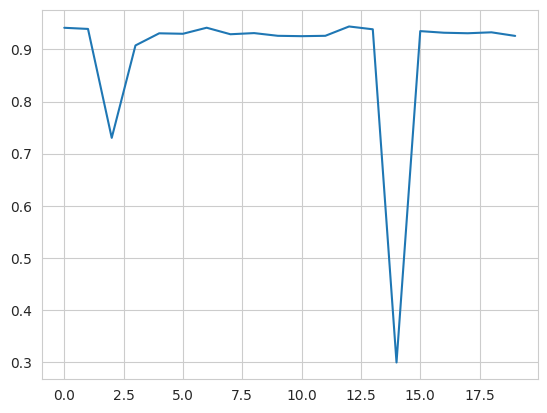

In [479]:
plt.plot([result['accuracy'] for result in res[pool_fn]])

In [230]:
res_sort = {k: res[k] for k in sorted(res)}

In [237]:
pl.DataFrame(res_sort).write_parquet("data/res1.pq")

(0.94, 0.965)

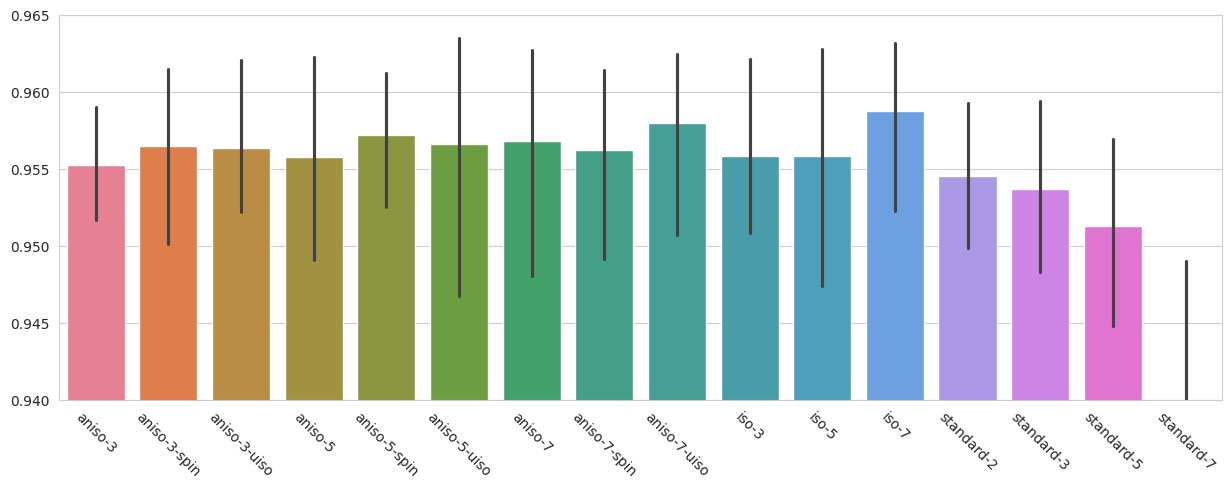

In [234]:
df = pl.DataFrame(res_sort).select(pl.all().struct.field("accuracy").name.keep())
# sns.barplot({'a':[0.9471, 0.9617, 0.9567, 0.9646, 0.9506, 0.9596, 0.9531, 0.9553, 0.9578, 0.9642, 0.9532, 0.9458, 0.9513, 0.953, 0.9582, 0.9526, 0.9578, 0.9631, 0.96, 0.9557]}, errorbar=("pi", 90))
plt.figure(figsize=(15, 5))
sns.barplot(df.to_pandas(), errorbar=("pi", 90))
plt.xticks(rotation=-45)
plt.ylim(0.940, 0.965)

In [418]:
math.log(0.0955)

-2.3486290314954523

In [481]:
k = kernels.QuadraticKernelIso2D(1, 1, 5, 1.9850)
k().squeeze().numpy(force=True)

array([[-1.0075567 , -0.6297229 , -0.50377834, -0.6297229 , -1.0075567 ],
       [-0.6297229 , -0.25188917, -0.12594458, -0.25188917, -0.6297229 ],
       [-0.50377834, -0.12594458, -0.        , -0.12594458, -0.50377834],
       [-0.6297229 , -0.25188917, -0.12594458, -0.25188917, -0.6297229 ],
       [-1.0075567 , -0.6297229 , -0.50377834, -0.6297229 , -1.0075567 ]],
      dtype=float32)

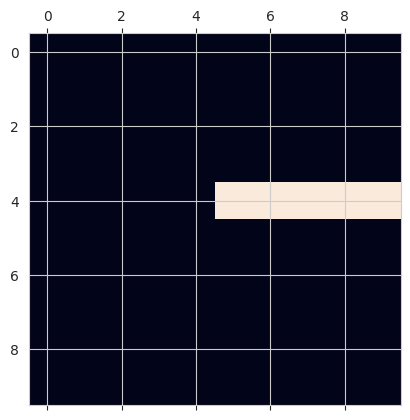

In [482]:
a = torch.zeros((1, 1, 10, 10), device="cuda")
a[..., 4, 5:] = 1
a.requires_grad_(True)
plt.matshow(a.squeeze().numpy(force=True))

In [483]:
c = convolutions.GenericConv2D(
    kernel=k,
    # conv=convolutions.LinearConv2D(),
    conv=convolutions.BroadcastSemifield.tropical_max().module(),
    # conv=convolutions.TropicalConv2D(is_max=True),
    stride=2, padding=2
).to('cuda')

In [484]:
r = c(a)
print(r.shape)
r

torch.Size([1, 1, 5, 5])


tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.3703, 0.4962, 0.4962],
          [0.0000, 0.0000, 0.8741, 1.0000, 1.0000],
          [0.0000, 0.0000, 0.3703, 0.4962, 0.4962],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]]], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [485]:
r.sum().backward()

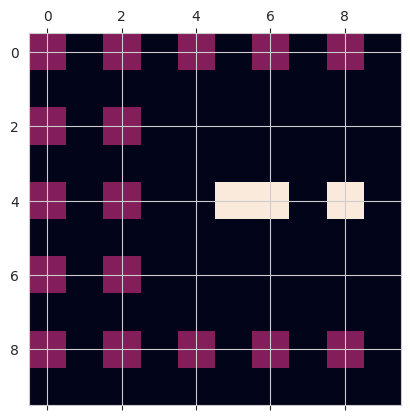

In [486]:
plt.matshow(a.grad.squeeze().numpy(force=True))

In [491]:
k.log_std.grad.numpy(force=True)

array([[1.7131002]], dtype=float32)

In [22]:
torch.manual_seed(0)
test_model = simple_lenet.LeNet(1, 10, "iso-5")

In [23]:
bx
res = test_model

LeNet(
  (net): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): GenericConv2D(
      padding=2, stride=2, groups=20
      (kernel): QuadraticKernelIso2D(1, 20, kernel_size=5)
      (conv): SelectConvFixedLazy()
    )
    (3): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): GenericConv2D(
      padding=2, stride=2, groups=50
      (kernel): QuadraticKernelIso2D(1, 50, kernel_size=5)
      (conv): SelectConvFixedLazy()
    )
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=500, bias=True)
    (8): ReLU()
    (9): Linear(in_features=500, out_features=10, bias=True)
  )
)

In [382]:
pg = kernels.QuadraticKernelIso2D(1, 1, 11, 2.6).pos_grid.squeeze()
pg.numpy(force=True)

array([[-5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -4., -4.,
        -4., -4., -4., -4., -4., -4., -4., -4., -4., -3., -3., -3., -3.,
        -3., -3., -3., -3., -3., -3., -3., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  4.,  4.,  4.,  4.,  4.,
         4.,  4.,  4.,  4.,  4.,  4.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
         5.,  5.,  5.,  5.],
       [-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5., -5., -4.,
        -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5., -5., -4., -3., -2.,
        -1.,  0.,  1.,  2.,  3.,  4.,  5., -5., -4., -3., -2., -1.,  0.,
         1.,  2.,  3.,  4.,  5., -5., -4., -3., -2., -1.,  0.,  1.,  2.,
         3.,  4.,  5.,

In [380]:
b = torch.linspace(
    -11 // 2 + 1, 11 // 2, 11, dtype=torch.float32
)
z_c = b.view(-1, 1).pow(2) + b.view(1, -1).pow(2)
z_c.numpy()

array([[50., 41., 34., 29., 26., 25., 26., 29., 34., 41., 50.],
       [41., 32., 25., 20., 17., 16., 17., 20., 25., 32., 41.],
       [34., 25., 18., 13., 10.,  9., 10., 13., 18., 25., 34.],
       [29., 20., 13.,  8.,  5.,  4.,  5.,  8., 13., 20., 29.],
       [26., 17., 10.,  5.,  2.,  1.,  2.,  5., 10., 17., 26.],
       [25., 16.,  9.,  4.,  1.,  0.,  1.,  4.,  9., 16., 25.],
       [26., 17., 10.,  5.,  2.,  1.,  2.,  5., 10., 17., 26.],
       [29., 20., 13.,  8.,  5.,  4.,  5.,  8., 13., 20., 29.],
       [34., 25., 18., 13., 10.,  9., 10., 13., 18., 25., 34.],
       [41., 32., 25., 20., 17., 16., 17., 20., 25., 32., 41.],
       [50., 41., 34., 29., 26., 25., 26., 29., 34., 41., 50.]],
      dtype=float32)

In [419]:
-pg.pow(2).sum(0).reshape(11, 11) / (4 * math.log(0.0955))

tensor([[5.3223, 4.3642, 3.6191, 3.0869, 2.7676, 2.6611, 2.7676, 3.0869, 3.6191,
         4.3642, 5.3223],
        [4.3642, 3.4062, 2.6611, 2.1289, 1.8096, 1.7031, 1.8096, 2.1289, 2.6611,
         3.4062, 4.3642],
        [3.6191, 2.6611, 1.9160, 1.3838, 1.0645, 0.9580, 1.0645, 1.3838, 1.9160,
         2.6611, 3.6191],
        [3.0869, 2.1289, 1.3838, 0.8516, 0.5322, 0.4258, 0.5322, 0.8516, 1.3838,
         2.1289, 3.0869],
        [2.7676, 1.8096, 1.0645, 0.5322, 0.2129, 0.1064, 0.2129, 0.5322, 1.0645,
         1.8096, 2.7676],
        [2.6611, 1.7031, 0.9580, 0.4258, 0.1064, 0.0000, 0.1064, 0.4258, 0.9580,
         1.7031, 2.6611],
        [2.7676, 1.8096, 1.0645, 0.5322, 0.2129, 0.1064, 0.2129, 0.5322, 1.0645,
         1.8096, 2.7676],
        [3.0869, 2.1289, 1.3838, 0.8516, 0.5322, 0.4258, 0.5322, 0.8516, 1.3838,
         2.1289, 3.0869],
        [3.6191, 2.6611, 1.9160, 1.3838, 1.0645, 0.9580, 1.0645, 1.3838, 1.9160,
         2.6611, 3.6191],
        [4.3642, 3.4062, 2.6611, 2.12